# Advanced Seminar Code

## Table of Contents

0. Initial Setup
1. Data Generation
2. Matching Availability of Patient and Bed
3. Class Generation for Each Patient and Bed
4. Class Generation to Confirm Schedules with First-Come-First-Serve (FCFS) and Multi-Appointment Scheduling
5. First-Class-First-Serve Approach to Confirm Schedules
6. Simulated Annealing Approach
7. Multi-Appointment Scheduling with Simulated Annealing
8. Evaluation of Results of FCFS and Multi-Appointment Scheduling

## 0. Initial Setup

In [171]:
# Import standard packages
import time
import random
import math
from math import e
import copy

In [172]:
# import third-party packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [173]:
# import local library imports

## 1. Data Generation

Each instance is characterized by three parameters ( r, κ, δ), where r is patient to bed ratio, κ is the number of slots per hour (larger κresults in shorter time slots and therefore patients will have more flexibility in selecting their available/target times), and finally, δ is the maximum allowable deviation from patient target times (presented in the number of slots). We generate m =   r ∗ n   instances, where n is the number of available beds and m is the number of patients.

Similar to a typical hemodialysis center, we consider 14 hours per day and 6 days per week (8:00 AM to 10:00 PM; Monday–Saturday). Patient available times for each day are generated independently. We split each day into two parts: morning and evening. Slots in each part of the day have an equal chance to be selected by patients (50% chance). More precisely, each day is composed of 14 ∗δslots. If a patient is available in the morning of a specific day (with 50% chance), then their ideal time slot is a random slot selected from { 1 , 2 , . . . , (14 ∗ κ) / 2 } . Likewise, if the patient is avail- able in the evening, his ideal time slot is randomly selected from { ((14 ∗ κ) / 2 ) + 1 , ((14 ∗ κ) / 2) + 2 , . . . , 14 ∗κ} . In case the selected evening slot doesn’t allow for a feasible dialysis appointment, a new slot is ran- domly selected. Note that it is possible that a patient is available in both parts of the day (with a 25% chance), i.e., the patient has two ideal time slots. In this case one appointment can be sched- uled in either of the slots (please note the one-day time separation between patient’s consecutive appointments). Dialysis treatment times are 4 hours, to comply with the average reported length of hemodialysis treatment. 6 We randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w k j weight in the objec- tive function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In the United States, a typical hemodialysis center, includ- ing our collaborating hemodialysis center, has approximately four hemodialysis patients per bed per day ( System, 2013 ). Consider- ing the expected growth in the demand for dialysis ( Medicare Pay- ment Advisory Commission, 2021 ), we evaluate the performance of our proposed BP algorithms for two patient-to-bed ratios of 4 and 5. For each patient-to-bed ratio, we consider time slot settings of 1 slot per hour and 2 slots per hour (half-hour slots). For each ratio-slot combination, we consider three maximum allowable de- viations from target times of 1 slot, 2 slots, and 4 slots. In terms of bed-patient size, the smallest instance starts with 10 beds and 40 patients, and the largest size represents a hemodialysis center with 20 beds and 100 patients. For every configuration in our test data set, we randomly generate 5 instances, resulting in a total of 270 instances, and report the average of 5 instances and the worst case for each configuration. 7

### 1a. Define some initial variables

I define some initial variables

In [174]:
## DECISION VARIABLES
# n = number of available beds
num_beds = 2
# m = number of patients
num_patients = 8

## VARIABLE RELATED TO THE DEVIATION 
# δ = maximum allowed deviation from patient target times based on number of slots
max_allowed_deviation = 1

## VARIABLES RELATED TO TIME
# κ = number of slots per hour , should not be over than 4! This is recommended from paper of Reihaneh et al.
num_of_slots_per_hour = 1
# Based on pg 37 of Rehihnahe et al. this is usually 3 required dialysis essions
num_required_dialysis_sessions = 3
# number of days per week
num_days_per_week = 6
# each day is composed of 14 hours per day ∗ δ slots
num_slots_per_day = 14 * num_of_slots_per_hour

## VARIABLES RELATED TO THE WEIGHT
# priority weights, key = ζ chance of having priority, value = w weight in the objecive function
priority_weights = {0.6: 1, 0.25: 1.4, 0.15: 2}
# weight list already predefined based on  Reihaneh's data generation scheme. Based on the priority assigned, the patient gets the 
# corresponding weight
weights_list = [1, 1.4, 2]

### 1b. Define an empty list containing all available time slots

Reihaneh et al.: For example, assuming 8 AM as the earliest availability of beds for K = 1, dialysis can only be scheduled at {8, 9, 10,..,} whereas for k = 4, dialysis may begin at {8, 8:15, 8:30, 9:00, 9:15, .. }. In this paper we consider K 
tion of time (i.e., .> 4 ) causes an exponential increase in solution
space, which is not justified as the average dialysis appointment
usually lasts 4 hours, and 5–10 minutes deviation does not affect
the show-up probability of patients.

In [175]:
# define a the list of open time slots based on the num of slots per hour. 
available_time_slot_list = []

# start at 8 am and end after 14 hours
start = 8
end = 8 + 14

Create a list of open time slots that will be used to create the schedule for the patients. As an example, the resulting open time slot list 
will be something like [830, 900, 930,..] assuming that there are 2 slots per hour, and 14 working hours per day. We assume that the possible 
maximum number of slots per hour is only 4 based on the approach of Reihaneh et al.

In [176]:
# for i in the range of the start time till the max number of time slots
for i in range(start, int(start + num_slots_per_day / num_of_slots_per_hour)):
    # add the top of the hours
    
    # if there is only one slot per hour then just concentrate on adding 00 to the end
    if num_of_slots_per_hour == 1:
        available_time_slot = int(str(i) + str("00"))
        available_time_slot_list.append(int(available_time_slot))
    else:
        available_time_slot_list.append(int(str(i) + str("00")))
        # for j in the range of the number of max time slots per hour
        for j in range(1, num_of_slots_per_hour):
            # add everything else thats not between the top of the hours eg not in between 8:00 and 9:00
            minute_of_hour = int((j / num_of_slots_per_hour) * 60)
            available_time_slot = int(str(i) + str(minute_of_hour))
            available_time_slot_list.append(int(available_time_slot))

# add the final end time
available_time_slot_list.append(int(str(end) + str("00")))
    

In [177]:
available_time_slot_list

[800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200]

### 1c. Define a list of random-generated priorities and assigned to the patients

This concept is based on Reihaneh et al.'s: I randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w k j weight in the objective function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In [178]:
# define the priority that the patient should bea ssigned and the probability of the patient getting them
priority = [1,2,3]
probabilities = [0.6, 0.25, 0.15]

# assign patient weights randomly based on the probabilities for all the patients in scope
random_priority = random.choices(priority, probabilities, k=num_patients)
random_priority

[1, 1, 1, 1, 2, 3, 2, 1]

### 1d. Define the prescribed dialysis hours

In [179]:
prescribed_dialysis_hours_list = []

for i in range(0, num_patients):
    prescribed_dialysis_hours = random.randint(3,5) * 3
    prescribed_dialysis_hours_list.append(prescribed_dialysis_hours)

In [180]:
prescribed_dialysis_hours_list

[12, 12, 12, 9, 9, 9, 9, 15]

### 1e. Create functions to set up a randomized dictionary to assign the availability of the patient and bed

Each patient will have an name, ideal schedule, priority, and weight

#### 1ei. Function to create the initial empty dict with available time slots for the patient and bed

if num of slots per hour == 1:
   then append all the hours to 00
if num of slots per hour > 1:


In [181]:
available_time_slot_list

[800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200]

In [182]:
# give higher preference to giving availability so generating 1
not_available = 0
available = 1

probabilities = [0.8, 0.2]

random_number = random.choices([available, not_available], probabilities)[0]

In [183]:
def create_empty_availability_dict():
    """
    Create the dictionary of patient and bed availabilities

    Args:

    Returns:
        availability_dict (dictionary): A dictionary of the availabilities marked as 0 or 1 for 
        the possible available time slots for the bed and patient
    """
    # create an empty dictionary that will be used to populate with the patient's availability based on the defined time slots
    availability_dict = {}

    # define as 1 or 0 for all available open time slots
    for i in available_time_slot_list:
        # define patient availability as 0 or 1 and add to dictionary
        availability = random.randint(0,1)
        # create entry in dictionary to match the open time slot and the patient availability
        availability_dict[i] = availability
            
    return availability_dict

In [184]:
def create_empty_bed_availability_dict():
    """
    Create the dictionary of bed availabilities with all starting at 0

    Args:

    Returns:
        availability_dict (dictionary): A dictionary of the availabilities marked as 0 for 
        the possible available time slots for the bed
    """
    # create an empty dictionary that will be used to populate with the patient's availability based on the defined time slots
    availability_dict = {}

    # define as 1 or 0 for all available open time slots
    for i in available_time_slot_list:
        # define patient availability as 0 or 1 and add to dictionary
        availability = 0
        # create entry in dictionary to match the open time slot and the patient availability
        availability_dict[i] = availability
            
    return availability_dict

#### 1eii. Create dictionary profile for the bed

In [185]:
def create_bed_profile(bed_number):
    """
    The function is to create patient profiles for each of the patients

    Args:
        patient_number (int): The length of the rectangle

    Returns:
        patient_profile_dict (dict): Return a dictionary of patient profiles with the patient number, 
        ideal schedule, priority and weight
    """
    bed_profile_dict = {}
    bed_availability_dict = {}

    # add the bed's name
    bed_profile_dict['bed'] = "b" + str(bed_number+1)

    # add the ideal schedule of the bed to the dictionary for six days of the week
    for i in range(1, 7): 
        # create the patient_availability_dict based on the function
        bed_empty_availability_dict = create_empty_bed_availability_dict()
        # the key is the day number
        bed_availability_dict[i] = bed_empty_availability_dict
    
    bed_profile_dict['bed_availability'] = bed_availability_dict
    
    return bed_profile_dict

In [186]:
# put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# all_patients_availability_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_beds_availablity_list = []

# append the patient profiles into the list
for bed in range(0, num_beds):
    all_beds_availablity_list.append(create_bed_profile(bed))

In [187]:
all_beds_availablity_list

[{'bed': 'b1',
  'bed_availability': {1: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   2: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   4: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   5: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    210

#### 1eiii. Create dictionary profile for the patient

In [188]:
def create_patient_profile(patient_number):
    """
    The function is to create patient profiles for each of the patients

    Args:
        patient_number (int): The length of the rectangle

    Returns:
        patient_profile_dict (dict): Return a dictionary of patient profiles with the patient number, 
        ideal schedule, priority and weight
    """
    patient_profile_dict = {}
    patient_availability_dict = {}

    # add the patient's name
    patient_profile_dict['patient'] = "p" + str(patient_number+1)

    # add the ideal schedule of the patient to the dictionary for six days of the week
    for i in range(1, 7): 
        # create the patient_availability_dict based on the function
        patient_empty_availability_dict = create_empty_availability_dict()
        patient_availability_dict[i] = patient_empty_availability_dict
    
    # add the priority of the patient
    patient_profile_dict['priority'] = random_priority[patient_number]
    
    # get the value of the weight from taking the random priority - 1 which then gives you the index from the weights list
    patient_profile_dict['weight'] = weights_list[random_priority[patient_number]-1]
    
    patient_profile_dict['prescribed_dialysis_hours'] = prescribed_dialysis_hours_list[patient_number]
    
    patient_profile_dict['patient_availability'] = patient_availability_dict
                                                
    return patient_profile_dict

In [189]:
# put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# patients_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_patients_availability_list = []

# append the patient profiles into the list
for patient in range(0, num_patients):
    print(patient)
    all_patients_availability_list.append(create_patient_profile(patient))

0
1
2
3
4
5
6
7


In [190]:
all_patients_availability_list

[{'patient': 'p1',
  'priority': 1,
  'weight': 1,
  'prescribed_dialysis_hours': 12,
  'patient_availability': {1: {800: 0,
    900: 1,
    1000: 1,
    1100: 1,
    1200: 1,
    1300: 0,
    1400: 1,
    1500: 0,
    1600: 0,
    1700: 1,
    1800: 1,
    1900: 0,
    2000: 0,
    2100: 1,
    2200: 1},
   2: {800: 1,
    900: 1,
    1000: 0,
    1100: 1,
    1200: 0,
    1300: 0,
    1400: 1,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 1,
    2000: 1,
    2100: 1,
    2200: 1},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 1,
    1500: 0,
    1600: 1,
    1700: 0,
    1800: 1,
    1900: 0,
    2000: 1,
    2100: 1,
    2200: 1},
   4: {800: 0,
    900: 0,
    1000: 0,
    1100: 1,
    1200: 1,
    1300: 0,
    1400: 1,
    1500: 1,
    1600: 0,
    1700: 1,
    1800: 1,
    1900: 0,
    2000: 1,
    2100: 1,
    2200: 0},
   5: {800: 1,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 

## 2. Matching Availability of Patient and Bed

### 2a. Create dictionary of where the availabilities of the bed and patient match

In [191]:
all_patients_matched_availability = []

# Loop through the patients
for dict2 in all_patients_availability_list:
    patient_matched_availability = {}
    patient_matched_availability['patient'] = dict2['patient']
    print(patient_matched_availability['patient'])

    # Loop through the days of the week
    for day in range(1, 7):
        print("day ", day)

        matched_availability = {}  # Initialize matched availability dictionary for each day
        empty_matched_availability = {}

        # Loop through the values in the bed_schedule and ideal_schedule
        for dict1 in all_beds_availablity_list:
            bed_availability = dict1['bed_availability']
            bed_id = dict1['bed']

            for key, patient_availability in dict2['patient_availability'][day].items():
                bed_availability_value = bed_availability[day].get(key, None)

                if bed_availability_value is not None and patient_availability == bed_availability_value == 0:
                    matched_availability.setdefault(day, {})
                    matched_availability[day][key] = bed_availability_value
                    empty_matched_availability[day] = matched_availability[day]

            # Assign matched availability for each bed separately
            patient_matched_availability_bed = patient_matched_availability.copy()
            patient_matched_availability_bed['bed'] = bed_id
            patient_matched_availability_bed['matched_availability'] = empty_matched_availability

            all_patients_matched_availability.append(patient_matched_availability_bed)

# Print the updated all_patients_matched_availability
for entry in all_patients_matched_availability:
    print(entry)


p1
day  1
day  2
day  3
day  4
day  5
day  6
p2
day  1
day  2
day  3
day  4
day  5
day  6
p3
day  1
day  2
day  3
day  4
day  5
day  6
p4
day  1
day  2
day  3
day  4
day  5
day  6
p5
day  1
day  2
day  3
day  4
day  5
day  6
p6
day  1
day  2
day  3
day  4
day  5
day  6
p7
day  1
day  2
day  3
day  4
day  5
day  6
p8
day  1
day  2
day  3
day  4
day  5
day  6
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}}}
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}}}
{'patient': 'p1', 'bed': 'b1', 'matched_availability': {3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1900: 0}}}
{'patient': 'p1', '

#### 2ai. Consolidate the list together to get a combination of patients and beds

In [192]:
consolidated_dict = {}

# Iterate over each entry in the original list
for entry in all_patients_matched_availability:
    patient = entry['patient']
    bed = entry['bed']
    matched_availability = entry['matched_availability']

    # Create a unique key for each bed-patient combination
    key = f"{bed}-{patient}"

    # Check if the key already exists in the consolidated dictionary
    if key in consolidated_dict:
        # If the key exists, update the matched_availability for the corresponding patient and bed
        consolidated_dict[key]['matched_availability'].update(matched_availability)
    else:
        # If the key doesn't exist, create a new entry in the consolidated dictionary
        consolidated_dict[key] = {
            'patient': patient,
            'bed': bed,
            'matched_availability': matched_availability
        }

# Print the consolidated dictionary
for entry in consolidated_dict.values():
    print(entry)


{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}, 2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1900: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0}, 5: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1600: 0, 1900: 0, 2100: 0}, 6: {900: 0, 1000: 0, 1600: 0, 1800: 0, 1900: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}, 2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1900: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0}, 5: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1600: 0, 1900: 0, 2100: 0}, 6: {900: 0, 1000: 0, 1600: 0, 1800: 0, 1900: 0}}}
{'patient': 'p2', 'bed': 'b1', 'matched_availability': {1: {800: 0

In [193]:
all_patients_matched_availability = consolidated_dict

In [194]:
all_patients_matched_availability

{'b1-p1': {'patient': 'p1',
  'bed': 'b1',
  'matched_availability': {1: {800: 0,
    1300: 0,
    1500: 0,
    1600: 0,
    1900: 0,
    2000: 0},
   2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1500: 0,
    1700: 0,
    1900: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0},
   5: {900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1600: 0,
    1900: 0,
    2100: 0},
   6: {900: 0, 1000: 0, 1600: 0, 1800: 0, 1900: 0}}},
 'b2-p1': {'patient': 'p1',
  'bed': 'b2',
  'matched_availability': {1: {800: 0,
    1300: 0,
    1500: 0,
    1600: 0,
    1900: 0,
    2000: 0},
   2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1500: 0,
    1700: 0,
    1900: 0},
   4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0},
   5: {900: 

### 2b. Create function to allocate POSSIBLE single appointment schedules based on the 3 - 5 consecutive values of 0 (which indicates availability) of the matched availability

In [195]:
def allocate_single_appointment_schedule(single_patient_matched_availability_dict):
    """
    The function allocates the single appointment schedules based on the 3 - 5 consecutive values of 0 (which indicates availability) of the matched availability of the bed and patient
    I define that it the schedule must match 3 - 5 times consecutively because that means that both patient and bed is free for 3 - 5 hours, thus it would be possible to schedule a
    dialysis treatment

    Args:
        single_patient_matched_availability_dict (dict): matched availability of a patient and a bed

    Returns:
        consecutive_zeroes (dict): Return a dictionary where the matched availability of the patient and bed is consecutive for between 3 - 5 times
    """
    consecutive_zeros = {}
    consecutive_count = 0
    temp_dict = {}
    last_day = None
    last_time = None

    for day, availability in single_patient_matched_availability_dict.items():
        # Iterate through each day and availability
        # day, availability == 3 {1500: 0, 2100: 0, 2200: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 1900: 0}
        for time, value in availability.items():
            # If the availability value is 0 (indicating availability)
            if value == 0:
                # If it's the first time, or the time is consecutive to the last processed time
                if last_day is None or last_time is None or (day == last_day and time == last_time + 100):
                    consecutive_count += 1
                    # Add the time to the temporary dictionary
                    temp_dict[time] = 0
                else:
                    # If the consecutive count is between 3 and 5 (inclusive)
                    if consecutive_count >= 3 and consecutive_count <= 5:
                        # Create a new dictionary for the day if it doesn't exist
                        if last_day not in consecutive_zeros:
                            consecutive_zeros[last_day] = {}
                        # Update the consecutive zeros for the day
                        consecutive_zeros[last_day].update(temp_dict)
                    # Start a new count for the current time slot
                    consecutive_count = 1
                    # Reset the temporary dictionary with the current time slot
                    temp_dict = {time: 0}
            else:
                # If the consecutive count is between 3 and 5 (inclusive)
                if consecutive_count >= 3 and consecutive_count <= 5:
                    if last_day not in consecutive_zeros:
                        # Create a new dictionary for the day if it doesn't exist
                        consecutive_zeros[last_day] = {}
                    # Update the consecutive zeros for the day
                    consecutive_zeros[last_day].update(temp_dict)
                # Reset the consecutive count
                consecutive_count = 0
                # Reset the temporary dictionary
                temp_dict = {}
            # Update the last processed day
            last_day = day
            # Update the last processed time
            last_time = time

    if consecutive_count >= 3 and consecutive_count <= 5:
        # If there are consecutive zeros at the end of the iteration
        if last_day not in consecutive_zeros:
            # Create a new dictionary for the day if it doesn't exist
            consecutive_zeros[last_day] = {}
        # Update the consecutive zeros for the day
        consecutive_zeros[last_day].update(temp_dict)

    print(consecutive_zeros)
    return consecutive_zeros


Create all_patient_schedules list to see a list of all patients and their possible allocated schedules based on the consecutive availabilities

In [196]:
for key in all_patients_matched_availability:
    print(key)

b1-p1
b2-p1
b1-p2
b2-p2
b1-p3
b2-p3
b1-p4
b2-p4
b1-p5
b2-p5
b1-p6
b2-p6
b1-p7
b2-p7
b1-p8
b2-p8


In [197]:
patient_bed_keys = list(all_patients_matched_availability.keys())

In [198]:
patient_bed_keys

['b1-p1',
 'b2-p1',
 'b1-p2',
 'b2-p2',
 'b1-p3',
 'b2-p3',
 'b1-p4',
 'b2-p4',
 'b1-p5',
 'b2-p5',
 'b1-p6',
 'b2-p6',
 'b1-p7',
 'b2-p7',
 'b1-p8',
 'b2-p8']

In [199]:
all_possible_patient_schedules = []

In [200]:
for key, entry in all_patients_matched_availability.items():
    print(entry)
    
    allocated_schedule_entry_single_patient_dict = {}
    empty_dict = {}
    print("This is the single patient matched availability:", entry['matched_availability'])
    print("This is the patient number:", entry['patient'])
    print("This is the bed number:", entry['bed'])
    #print(entry['matched_availability'])
    consecutive_zeroes_dict = allocate_single_appointment_schedule(entry['matched_availability'])
    
    print("this is the consecutive_zeroes_dict")
    print(consecutive_zeroes_dict)

    # if you get back something with a dictionary of consecutive availability:
    if len(consecutive_zeroes_dict) > 0:
        allocated_schedule_entry_single_patient_dict['patient'] = entry['patient']
        allocated_schedule_entry_single_patient_dict['bed'] = entry['bed']
        allocated_schedule_entry_single_patient_dict['possible_allocated_schedule'] = consecutive_zeroes_dict 
        all_possible_patient_schedules.append(allocated_schedule_entry_single_patient_dict)
        print(" this is the dictionary i added")
        print(allocated_schedule_entry_single_patient_dict)
    # if not, then go to the next patient
    else:
        continue
        

{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}, 2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1900: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0}, 5: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1600: 0, 1900: 0, 2100: 0}, 6: {900: 0, 1000: 0, 1600: 0, 1800: 0, 1900: 0}}}
This is the single patient matched availability: {1: {800: 0, 1300: 0, 1500: 0, 1600: 0, 1900: 0, 2000: 0}, 2: {1000: 0, 1200: 0, 1300: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1500: 0, 1700: 0, 1900: 0}, 4: {800: 0, 900: 0, 1000: 0, 1300: 0, 1600: 0, 1900: 0, 2200: 0}, 5: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1600: 0, 1900: 0, 2100: 0}, 6: {900: 0, 1000: 0, 1600: 0, 1800: 0, 1900: 0}}
This is the patient number: p1
This is the bed number: b1
{2: {1500: 0, 1

In [201]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0},
   4: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0},
   4: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p2',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0},
   4: {1000: 0, 1100: 0, 1200: 0},
   5: {1600: 0, 1700: 0, 1800: 0}}},
 {'patient': 'p2',
  'bed': 'b2',
  'possible_allocated_schedule': {2: {1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0},
   4: {1000: 0, 1100: 0, 1200: 0},
   5: {1600: 0, 1700: 0, 1800: 0}}},
 {'patient': 'p3',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {800: 0,
    900: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   3: {1100: 0, 1200: 0, 1300: 0},
   4: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0},
   6: {1200: 0, 1300: 0, 1400

## 3. Class Generation for each patient and bed

The schedules of each patient and bed will then be a separate thing based on FCFS and 

Data structures to use from before to create classes of beds and patients
1. all_beds_availability_list = dictionary of availability of beds
2. all_patients_availability_list = dictionary of availabilty of patients
2. all_possible_patient_schedules = list of possible allocations of a patient to a certain bed

### 3a. Define some classes for the patient and bed

In [202]:
# define a class to generate set of m patient objects
class patient: 
    def __init__(self, patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover):
        self.patient_id = patient_id
        # Total dialysis hours prescribed for j
        self.prescribed_total_dialysis_hours = prescribed_total_dialysis_hours 
        # processing time: the patient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), 
        # dialysis time on the dialysis machine, and take-offtime (a technician takes the patient off the bed, disconnects them from the dialysis machine and cleans the bed).
        self.processing_time = processing_time 
        # ideal time slots for starting dialysis sessions
        self.ideal_schedule = ideal_schedule
        # set of feasible time slots for j
        self.confirmed_schedule = confirmed_schedule
        # weight of patient j in objective function
        self.weight = weight 
        # Number of leftover appointments of j
        self.leftover = leftover 
        
    def __str__(self):
        return f"{self.patient_id}"  # for debug mode
    
    def add_confirmed_schedule(confirmed_schedule):
        self.confirmed_schedule.append(confirmed_schedule)
        
    def calculate_schedule_length(self):
        return len(self.confirmed_schedule)

In [203]:
# define a class to generate set of n identical bed objects
class bed:
    def __init__(self, bed_id, bed_schedule):
        self.bed_id = bed_id
        self.bed_schedule = bed_schedule
    
    def __str__(self):
        return f"{self.bed_id}"  # for debug mode

### 3b. Instantiate some objects for the patient and bed

#### 3bi. Instantiate object list for the patient

In [204]:
patient_objects_list = []

for item in all_patients_availability_list:
    patient_id = item['patient']
    ideal_schedule = item['patient_availability']
    weight = item['weight']
    priority = item['priority']
    prescribed_total_dialysis_hours = item['prescribed_dialysis_hours']
    processing_time = 0
    confirmed_schedule = {}
    leftover = 0
    patient_objects_list.append(patient(patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover))

In [205]:
for obj in patient_objects_list:
    print(obj.patient_id)
    print(obj.calculate_schedule_length())

p1
0
p2
0
p3
0
p4
0
p5
0
p6
0
p7
0
p8
0


#### 3bii. Instantiate object list for the patient for multi appointment scheduling

In [206]:
multi_appt_patient_objects_list = patient_objects_list.copy()

#### 3biii. Instantiate object list for the bed

In [207]:
bed_objects_list = []

for item in all_beds_availablity_list:
    bed_id = item['bed']
    bed_schedule = item['bed_availability']
    print(bed_id)
    print(bed_schedule)
    bed_objects_list.append(bed(bed_id, bed_schedule))

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 

In [208]:
for obj in bed_objects_list:
    print(obj.bed_id)

b1
b2


## 4. Class Generation to Confirm Schedules with First-Come-First-Serve (FCFS) and Multi-Appointment Scheduling

### 4a. Function to Change the bed occupancy

In [209]:
# Example for testing
# bed_id = "b1"
# patient_day = 1
# patient_schedule = {1: {1600:0,1700:0,1800:0}}
# patient_id = "p1"
def change_bed_occupancy(bed_id, patient_schedule, patient_day, patient_id):
    # change the bed occupancy from available (meaning 0) to the patient id
    for bed in bed_objects_list:
        # print("this is the bed_id whose bed occupancy i will change to the patient id ", bed.bed_id)
        if bed.bed_id == bed_id:
            # print("yes")
            # change the occupancy based on the possible_sched
            # print("this is the patient_day whose bed occupancy i will change to the patient ID", patient_id, patient_day)
            for time_p in patient_schedule:
                # print(bed_schedule[patient_day][time_p])
                # change from 0 to the patient_id
                # print("This is the time that I will change to 0 ", bed.bed_schedule[patient_day][time_p])
                bed.bed_schedule[patient_day][time_p] = patient_id

In [210]:
def free_up_bed_occupancy(bed_id, patient_schedule, patient_day, patient_id):
    # change the bed occupancy from available (meaning 0) to the patient id
    for bed in bed_objects_list:
        # print("this is the bed_id whose bed occupancy i will free up", bed.bed_id)
        # print("this is the patient_schedule whose bed occupancy i will free up ", patient_schedule)
        if bed.bed_id == bed_id:
            # print("yes")
            # change the occupancy based on the possible_sched
            # print("this is the patient_day ", patient_day)
            for time_p in patient_schedule:
                # print("This is the time that I will change to 0 ", time_p)
                # change from 0 to the patient_id
                bed.bed_schedule[patient_day][time_p] = 0

### 4b. Checks if Feasible, both should be true before the bed occupancy is changed

### 4c. Check bed is not taken by another patient

In [211]:
# requested_time_slot = {1600:0,1700:0,1800:0}}
# requested_day = 1
# requested_time = 1600

def check_bed_availability(bed_id, requested_time_slot, requested_day):
    availablility_counter = 0
    for bed in bed_objects_list:
        if bed.bed_id == bed_id:
            # check if its free
            for requested_time in requested_time_slot:
                if bed.bed_schedule[requested_day][requested_time] == 0: 
                    # print("requested day ", requested_day, " requested time ", requested_time)
                    availablility_counter += 1

            if availablility_counter == len(requested_time_slot):
                return True
            else:
                return False


## 5. First-Come-First-Serve Approach to Confirm Schedules

"In the current scheduling policy, patients are scheduled one at a time and based on the order that they are introduced to the center on a First-Come-First-Serve (FCFS) basis. To respect the one- day separation constraint, patients are only scheduled on either odd or even days. Although schedules that use both odd and even days are also feasible, it was our observation that allowing for such schedules only worsens the schedules obtained using the FCFS policy. 

We implement this FCFS policy as follows. 

For each patient j, we select schedule a ∈ j with minimum ψ a that is feasible with respect to the above constraints and can also be feasibly assigned to a bed (i.e., has no overlap with slots occupied by patients { 1 , . . . , j −1 } ). 

Recall that  j only contains schedules that are within δslot deviations from patient j’s ideal time slots. There- fore, the number of appointments in selected schedule a , may be less that the prescribed appointments for j. 

In that case, the leftover appointments, if any, are scheduled in one of the remaining feasible time slots. Figures 3 and 4 demonstrate the quality of schedules when em- ploying the FCFS policy as compared to the optimal schedules ob- tained by our proposed Enhanced CG-embedded BP algorithm, in terms of the percentage of leftover appointments (i.e.,  L ) and the hours of deviations per patient (i.e.,  D ). 

The optimal policy consistently produces schedules that outperform the FCFS policy in terms of the leftover appointments (average improvement of 98%) and the average deviation (average improvement of 46%). However, we observed that in some cases, the optimal policy returns sched- ules with higher appointment deviations (  D ), in order to find schedules that result in considerably lower leftover appointments. This is one of the major oversights that would be inevitable us- ing the FCFS policy. Tables A.5 and A.6 report the detailed results on the performance of the optimal policy developed using the En- hanced CG-embedded algorithm compared to the FCFS policy."

### 5a. Implement functions from 4b

See preview of all_possible_patient_schedules

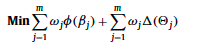

In [212]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0},
   4: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0},
   4: {800: 0, 900: 0, 1000: 0}}},
 {'patient': 'p2',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0},
   4: {1000: 0, 1100: 0, 1200: 0},
   5: {1600: 0, 1700: 0, 1800: 0}}},
 {'patient': 'p2',
  'bed': 'b2',
  'possible_allocated_schedule': {2: {1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0},
   4: {1000: 0, 1100: 0, 1200: 0},
   5: {1600: 0, 1700: 0, 1800: 0}}},
 {'patient': 'p3',
  'bed': 'b1',
  'possible_allocated_schedule': {2: {800: 0,
    900: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   3: {1100: 0, 1200: 0, 1300: 0},
   4: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0},
   6: {1200: 0, 1300: 0, 1400

Set some initial variables

In [213]:
patient_counter = 0
patient_schedules_in_list = []
patient_schedules_out_list = []

#### 5ai. Reserve beds for patients on a first come first serve basis

In [214]:
def reserve_patient_beds(all_possible_patient_schedules):
    # Example for testing
    # bed_id = "b1"
    # patient_day = 1
    # patient_schedule = {1: {1600:0,1700:0,1800:0}}
    # patient_id = "p1"
    #change_bed_occupancy(bed_id, single_patient_day_schedule, patient_day, patient_id)

    ## Look through the first matched availability
    for patient_sched in all_possible_patient_schedules:
        patient_schedules_out_dict = {}
        patient_schedules_in_dict = {}
        days = list(patient_sched['possible_allocated_schedule'].keys())
        # print("this is the length ", len(patient_sched['possible_allocated_schedule']))
        for requested_day in days:
            # print("this is the requested day ", requested_day)
            # print("this is patient_sched['possible_allocated_schedule'][requested_day]", patient_sched['possible_allocated_schedule'][requested_day])
            requested_sched = patient_sched['possible_allocated_schedule'][requested_day]
            # print(patient_sched['possible_allocated_schedule'])
            bed_id = patient_sched['bed']
            #check_bed_availability(bed_id, requested_time_slot, requested_day)
            # print("first if statement ", bed_id, requested_sched, " day ", requested_day, " for patient ", patient_sched['patient'])
            if check_bed_availability(bed_id, requested_sched, requested_day) == True:
                # print("you passed the bed availablity test") 

                ## Add the patient's schedule to the patient_schedules_in_dict and list
                patient_schedules_in_dict = {
                    'patient': patient_sched['patient'],
                    'bed': patient_sched['bed'],
                    'day': requested_day,
                    'schedule': patient_sched['possible_allocated_schedule'][requested_day]
                }
                patient_schedules_in_list.append(patient_schedules_in_dict)

                #print(requested_sched)
                change_bed_occupancy(bed_id, requested_sched, requested_day, patient_sched['patient'])

                ## Remove the patient schedule from patient_schedules_out_list
                if patient_schedules_in_dict in patient_schedules_out_list:
                    patient_schedules_out_list.remove(patient_schedules_in_dict)

            else:
                # bed turns out is not available so add the patient's schedule to the patient_schedules_out_dict and list
                patient_schedules_out_dict = {
                    'patient': patient_sched['patient'],
                    'bed': patient_sched['bed'],
                    'day': requested_day,
                    'schedule': patient_sched['possible_allocated_schedule'][requested_day]
                }
                # if the schedule is not already in the out list, then add it to the out list
                if patient_schedules_out_dict not in patient_schedules_out_list:
                    patient_schedules_out_list.append(patient_schedules_out_dict)
                    # print("Unfortunately this ", patient_schedules_out_dict, " could not be added the bed is not available on", requested_day)

                # make sure to remove it from the patient_schedules_in_list
                if patient_schedules_out_dict in patient_schedules_in_list:
                    patient_schedules_in_list.remove(patient_schedules_out_dict)

                # make sure to free up the bed occupancy because it was previously in the in_list
                free_up_bed_occupancy(bed_id, requested_sched, requested_day, patient_sched['patient'])
                
    return patient_schedules_out_list, patient_schedules_in_list

In [215]:
patient_schedules_out_list, patient_schedules_in_list = reserve_patient_beds(all_possible_patient_schedules)
                
print("this is the patient_schedules_out_list", patient_schedules_out_list)
print("this is the patient_schedules_in_list", patient_schedules_in_list)

this is the patient_schedules_out_list [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 

In [216]:
for bed in bed_objects_list:
    print(bed.bed_id)
    print(bed.bed_schedule)

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p4', 1300: 'p4', 1400: 'p4', 1500: 0, 1600: 'p6', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p7', 1300: 'p7', 1400: 'p7', 1500: 0, 1600: 'p1', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 'p8', 1700: 'p8', 1800: 'p8', 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p6', 1400: 'p6', 1500: 'p6', 1600: 'p6', 1700: 0, 1800: 0, 1900: 'p4', 2000: 'p4', 2100: 'p4', 2200: 'p4'}, 5: {800: 0, 900: 0, 1000: 0, 1100: 'p6', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 'p2', 1700: 'p2', 1800: 'p2', 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p3', 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 'p4', 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p4', 1300: 'p4', 1400: 'p4', 1500: 0, 1600: 

#### 5aii. Check the spacing between the times in terms of how far apart they are regardless if they are occupying another bed

In [217]:
def check_time_spacing(patient_schedules_out_list, patient_schedules_in_list):
    assigned_days = {}

    patient_schedules_in_list_copy = patient_schedules_in_list.copy()
    
    for schedule in patient_schedules_in_list_copy:
        patient = schedule['patient']
        bed = schedule['bed']
        day = schedule['day']
        schedule_data = schedule['schedule']

        # Check if the patient is already assigned a day
        if patient in assigned_days:
            # print(assigned_days)
            # Check if the assigned day is consecutive to the current day
            if assigned_days[patient] + 1 == day:
                # Add the patient's information to the patient_schedule_out_list
                patient_schedule_out_dict = {
                    'patient': patient,
                    'bed': bed,
                    'day': assigned_days[patient] + 1,
                    'schedule': schedule_data
                }
                patient_schedules_out_list.append(patient_schedule_out_dict)
                # Remove the conflicting appointment from patient_schedules_in_list
                patient_schedules_in_list.remove(schedule)

                free_up_bed_occupancy(bed, schedule_data, day, patient)
            else:
                assigned_days[patient] = day
        else:
            assigned_days[patient] = day
            
    return patient_schedules_out_list, patient_schedules_in_list, assigned_days

In [218]:
multi_appt_assigned_days = {}

In [219]:
patient_schedules_out_list, patient_schedules_in_list, multi_apptassigned_days = check_time_spacing(patient_schedules_out_list, patient_schedules_in_list)

print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p4', 'bed':

In [220]:
for bed in bed_objects_list:
    print(bed.bed_id)
    print(bed.bed_schedule)

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p4', 1300: 'p4', 1400: 'p4', 1500: 0, 1600: 'p6', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p7', 1300: 'p7', 1400: 'p7', 1500: 0, 1600: 'p1', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 'p8', 1700: 'p8', 1800: 'p8', 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 'p6', 1400: 'p6', 1500: 'p6', 1600: 'p6', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 'p2', 1700: 'p2', 1800: 'p2', 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p3', 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 'p4', 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p4', 1300: 'p4', 1400: 'p4', 1500: 0, 1600: 'p6', 1700: 0, 

#### 5aiii. Remove non-consecutive schedules

In [221]:
def remove_non_consecutive_schedules(patient_schedules_out_list, patient_schedules_in_list):
    modified_list = []

    for entry in patient_schedules_in_list:
        schedule = entry['schedule']
        sorted_times = sorted(schedule.keys())

        # Find consecutive intervals
        consecutive_intervals = []
        current_interval = []

        for time in sorted_times:
            if not current_interval or time - current_interval[-1] == 100:
                current_interval.append(time)
            else:
                consecutive_intervals.append(current_interval)
                current_interval = [time]

        consecutive_intervals.append(current_interval)

        # Filter out non-consecutive intervals
        filtered_intervals = [interval for interval in consecutive_intervals if len(interval) > 1]

        # Create modified schedule dictionary
        modified_schedule = {'patient': entry['patient'], 'bed': entry['bed'], 'day': entry['day'], 'schedule': {}}

        if len(filtered_intervals) > 0:
            # Append only the first consecutive interval
            first_interval = filtered_intervals[0]
            for time in first_interval:
                modified_schedule['schedule'][time] = schedule[time]

        modified_list.append(modified_schedule)

    return modified_list


In [222]:
patient_schedules_in_list = remove_non_consecutive_schedules(patient_schedules_out_list, patient_schedules_in_list)

In [223]:
# Print the modified schedule list
for entry in patient_schedules_in_list:
    print(entry)

{'patient': 'p1', 'bed': 'b1', 'day': 2, 'schedule': {1500: 0, 1600: 0, 1700: 0, 1800: 0}}
{'patient': 'p1', 'bed': 'b1', 'day': 4, 'schedule': {800: 0, 900: 0, 1000: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 2, 'schedule': {1500: 0, 1600: 0, 1700: 0, 1800: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 4, 'schedule': {800: 0, 900: 0, 1000: 0}}
{'patient': 'p2', 'bed': 'b1', 'day': 5, 'schedule': {1600: 0, 1700: 0, 1800: 0}}
{'patient': 'p2', 'bed': 'b2', 'day': 5, 'schedule': {1600: 0, 1700: 0, 1800: 0}}
{'patient': 'p3', 'bed': 'b1', 'day': 3, 'schedule': {1100: 0, 1200: 0, 1300: 0}}
{'patient': 'p3', 'bed': 'b1', 'day': 6, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 3, 'schedule': {1100: 0, 1200: 0, 1300: 0}}
{'patient': 'p3', 'bed': 'b2', 'day': 6, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p4', 'bed': 'b1', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0}}
{'patient': 'p4', 'bed': 'b1', 'day': 3, 'schedule': {1700: 0, 1800: 0, 1900: 0}}
{'

#### 5aiv. Check that patient does not already occupy another bed!

In [224]:
def remove_occupied_beds(patient_schedules_out_list, patient_schedules_in_list):
    assigned_beds = {}
    # Create a copy of the patient_schedules_in_list to avoid modifying it during iteration
    patient_schedules_in_list_copy = patient_schedules_in_list.copy()
    
    # shufflel ist
    random.shuffle(patient_schedules_in_list_copy)
    
    for schedule in patient_schedules_in_list_copy:
        patient_day = str(schedule['patient']) + str(schedule['day'])
        patient = schedule['patient']
        bed = schedule['bed']
        day = schedule['day']
        schedule_data = schedule['schedule']
        
        # Check if the patient is already assigned a day
        if patient_day in assigned_beds and patient in multi_apptassigned_days:
            # Add the patient's information to the patient_schedule_out_list
            patient_schedules_out_dict = {
                'patient': patient,
                'bed': bed,
                'day': multi_apptassigned_days[patient] + 1,
                'schedule': schedule_data
            }
            patient_schedules_out_list.append(patient_schedules_out_dict)
            # Remove the conflicting appointment from patient_schedules_in_list
            patient_schedules_in_list.remove(schedule)

            free_up_bed_occupancy(bed, schedule_data, day, patient)
        else:
            assigned_beds[patient_day] = bed
    
    return patient_schedules_out_list, patient_schedules_in_list

In [225]:
patient_schedules_out_list, patient_schedules_in_list = remove_occupied_beds(patient_schedules_out_list, patient_schedules_in_list)

In [226]:
print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1000: 0, 1100: 0, 1200: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b1', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 2, 'schedule': {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p3', 'bed': 'b2', 'day': 4, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}}, {'patient': 'p4', 'bed': 'b1', 'day': 2, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1700: 0, 1800: 0, 1900: 0}}, {'patient': 'p4', 'bed':

### 5b. FCFS Class

In [227]:
class FCFS_confirmed_schedule:
    def __init__(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        # patient schedules that work out are stored inside
        self.patient_schedules_in = patient_schedules_in
        # patient schedules that did not work out get stored outside
        self.patient_schedules_out = patient_schedules_out
        # objective function value to minimize
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty 
    
    
    ## NOT NEEDED?
    def copy_FCFS_confirmed_schedule(self):
        new_FCFS_confirmed_schedule = FCFS_confirmed_schedule()
        new_patient_id = copy.deepcopy(patient_id)
        new_patient_schedules_in = copy.deepcopy(self.patient_schedules_in)
        new_patient_schedules_out = copy.deepcopy(self.patient_schedules_out)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_FCFS_confirmed_schedule
    
    ## NOT NEEDED?
    def add_time_slot(self, time_slot):
        """
        add possible time slot to the schedule
        """
        # update to the schedules
        self.patient_schedules_in.add(time_slot)
        self.patient_schedules_out.remove(time_slot)
        
    
    ## NOT NEEDED?
    def remove_time_slot(self, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.patient_schedules_in.remove(time_slot)
        self.patient_schedules_out.add(time_slot)
    
    ## NOT NEEDED?
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    ## NOT NEEDED?
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
    
    ## NOT NEEDED?
    def make_feasible(self, time_slot):
        """
        remove time slot that is not feasible
        """
        if check_if_feasible == False:
            self.FCFS_confirmed_schedule.remove_time_slot(time_slot)
        
    ## NOT NEEDED?
    def check_if_feasible(self):
        """
        if it is feasible with the schedule of the patients
        """
        # another patient does not currently stay there
    

### 5c. Initialize the FCFS Schedule Object

In [228]:
patient_schedules_in = patient_schedules_in_list
patient_schedules_out = patient_schedules_out_list
objective = 0
contribution = 0
penalty = 0

In [229]:
new_final_FCFS_schedule = FCFS_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)

In [230]:
# TODO Create function from this
# Get the schedule of the patient and assign to the new final FCFS schedule
for obj in patient_objects_list:
    schedule_list = []
    for patient_sched in patient_schedules_in:
        if obj.patient_id == patient_sched['patient']:
            schedule_entry = {}
            schedule_entry['bed'] = patient_sched['bed']
            schedule_entry['day'] = patient_sched['day']
            schedule_entry['schedule'] = patient_sched['schedule']
            schedule_list.append(schedule_entry)
            obj.confirmed_schedule = schedule_list

### 5d. Calculate the Leftover appointment

In [231]:
# calculate leftover appointments
for obj in patient_objects_list:
    obj.leftover = num_required_dialysis_sessions - obj.calculate_schedule_length()

In [232]:
# TODO CHANGE THE DOCSTRING
def count_leftover_appointments(num_allocated_appointments):
    """
    The function is to create patient profiles for each of the patients

    Args:
        patient_number (int): The length of the rectangle

    Returns:
        patient_profile_dict (dict): Return a dictionary of patient profiles with the patient number, 
        ideal schedule, priority and weight
    """
    # beta_j is the total number of leftover appointmnets
    return num_required_dialysis_sessions - num_allocated_appointments

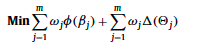

### 5e. Calculate the Penalty

In [233]:
# count penalty
def count_penalty(num_leftover_appointments):
    # the number of leftover appointmnets are 0, then there is no penalty
    if num_leftover_appointments == 0:
        penalty = 0
    else:
        penalty = (num_required_dialysis_sessions * num_patients * max_allowed_deviation) ** num_leftover_appointments
    
    return penalty

### 5f. Find total hours of the confirmed schedule

In [234]:
def count_total_confirmed_hours(patient_sched):
    total_hours = 0

    for schedule in patient_sched:
        schedule_hours = len(schedule['schedule'])
        total_hours += schedule_hours

    return total_hours

### 5g. Objective Function and Constraints

Let **J = { 1 , . . . , m } be the set of $m$ patients** to be allocated to a **set of $n$ identical beds I = { 1 , . . . , n }** over a six-day working week, where each day is 14-hour long. Each patient j ∈ Jis prescribed a total of $t_j$ hours of dialysis per week (split into ηequally-long dialysis appointments, usually η= 3 ). 
$p_j$ = Each dialysis appointment of a patient j ∈ J, therefore, has a processing time $p_j$ which includes the pa- tient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), dialysis time on the dialysis machine, and take-offtime (a technician takes thepatient offthebed, discon- nects them from the dialysis machine and cleans the bed).

**Main objective**: Therefore, our main objective is to maximize the number of appointments that are scheduled according to patients’ availability (with a minimum of $\delta$ slots deviation from their ideal time slots). Equivalently, we penalize the failure to assign any number of the required $\nu$ appointments for each patient (i.e., leftover ap-
pointments) as well as the total deviations in the patient’s weekly schedule.

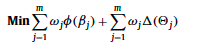

#### 5gi. First Term

**Objective** : minimize the total leftover appointments penalty, which is calculated as the equation below where $w_j$ is a pre-specified weight computed based on the severity of the patient’s health condition

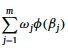

**Explanation of terms below:**

$\theta_j$ $\subseteq$ $S$ be the set of all time slots that patient j's dialysis appointments are allocated to

$\beta_j$ = total number of leftover appointments in schedule $\theta_j$ of patient $j$

 is total number of leftover appointments in schedule $\theta_j$ of patient j 

$\phi$ $(\beta_j)$ = penalty associated with $\theta$ with $\phi$(0) = 0 and $\phi$(1) $\geq \eta * m * \delta$ , and we assume $\phi$(3) $\gg$ $\phi$(2) $\gg$ $\phi$(1) where the highest priority is to minimize the number of patients with 3 leftover appointments.

$\eta$ = number of required dialysis sessions of patients,
$m$ = number of patients,
$\delta$ = allowed deviation limit from patients' target slots

Each patient j ∈ J is prescribed a total of $t_j$ hours of dialysis per week (split into $\eta$ equally-long dialysis appointments, usually $\eta$ = 3 ) based on page 37 of Reihnahe et al.

In [235]:
def get_first_term(weight, leftover):
    return weight * count_penalty(leftover)

#### 5gii. Second Term

In [236]:
def get_second_term(weight, prescribed_total_diaylsis_hours, confirmed_schedule):
    hour_diff = prescribed_total_dialysis_hours - count_total_confirmed_hours(confirmed_schedule)
    
    if hour_diff < 0: 
        multiplier = 0
    else:
        multiplier = hour_diff
    
    return weight * multiplier

#### 5giii. Objective function

In [237]:
def calculate_objective_function(patient_id, confirmed_schedule, weight, leftover, prescribed_total_dialysis_hours): 
    # print(patient_id)
    # print(confirmed_schedule)
    # print("Weight is ", weight, " and the penalty is ", count_penalty(leftover), "the prescribed dialysis hours is ", prescribed_total_dialysis_hours)
    # print("The number of confirmed time slots is ", len(confirmed_schedule), " and the total confirmed hours is ", count_total_confirmed_hours(confirmed_schedule))
    first_term_result = get_first_term(weight, leftover)
    second_term_result = get_second_term(weight, prescribed_total_dialysis_hours, confirmed_schedule)
    
    num_confirmed_timeslots = len(confirmed_schedule)
    obj_function_inc = first_term_result + second_term_result
    count_one = 0
    count_two = 0
    count_three = 0
    count_zero = 0
    
    if len(confirmed_schedule) == 1:
        count_one = 1
    elif len(confirmed_schedule) == 2:
        count_two = 1
    elif len(confirmed_schedule) == 3:
        count_three = 1
    elif len(confirmed_schedule) == 0:
        count_zero = 1
        
    # print("this is from  calculate_obj_function", obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero)
        
    return obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero

In [238]:
obj_function = 0
total_confirmed_timeslots = 0
total_count_one = 0
total_count_two = 0
total_count_three = 0
total_count_zero = 0

for obj in patient_objects_list:
    obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, 
                                                     obj.leftover, obj.prescribed_total_dialysis_hours)
    obj_function += obj_function_inc
    total_confirmed_timeslots += num_confirmed_timeslots
    total_count_one += count_one
    total_count_two += count_two
    total_count_three += count_three
    total_count_zero += count_zero

In [239]:
obj_function

21503.8

In [240]:
total_confirmed_timeslots

12

In [241]:
total_count_one

3

In [242]:
total_count_two

3

In [243]:
total_count_three

1

In [244]:
total_count_zero

1

In [245]:
for bed in bed_objects_list:
    print(bed.bed_id)
    print(bed.bed_schedule)

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 'p8', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 'p4', 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 'p4', 1300: 'p4', 1400: 'p4', 1500: 0, 1600: 'p6', 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800:

In [246]:
# psi is at least this, so can have it increase as there are more leftover appointments. They tried delta from 1 to 2, and even tried delta = 4 which is on p 43.
# have some increasing function at the end, and can square and cube it 
# in the second term, it looks at how many of the timeslots are outside of their prescribed times. See def of delta in page 42. patient should choose preferences 
# that match the length of time that they are scheduled for dialysis. Then need to choose random numbers from 3 to 5 and x by 3 to make that the total prescribed hours

In [247]:
# TODO: BED OBJECT LIST IS WRONG! it does not reflect the correct occupancy of the bed!

Dialysis treatment times are 4 hours to comply with the average reported length of hemodialysis treatment , but it is usually between 3 to 5 hours. So lets find a time when both patients and beds are free at the same time and store it in a dictionary

## 6. Multi-Appointment Scheduling to Confirm Schedules

### 6a. Multi-Appointment Schedule Class

In [248]:
class multi_appt_confirmed_schedule:
    def __init__(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        # patient schedules that work out are stored inside
        self.patient_schedules_in = patient_schedules_in
        # patient schedules that did not work out get stored outside
        self.patient_schedules_out = patient_schedules_out
        # objective function value to minimize
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty 
    
    
    ## NOT NEEDED?
    def copy_multi_appt_confirmed_schedule(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        new_multi_appt_confirmed_schedule = multi_appt_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)
        new_patient_id = copy.deepcopy(patient_id)
        new_patient_schedules_in = copy.deepcopy(self.patient_schedules_in)
        new_patient_schedules_out = copy.deepcopy(self.patient_schedules_out)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_multi_appt_confirmed_schedule
    
    ## NOT NEEDED?
    def add_time_slot(self, time_slot):
        """
        add possible time slot to the schedule
        """
        # update to the schedules
        self.patient_schedules_in.add(time_slot)
        self.patient_schedules_out.remove(time_slot)
        
    
    ## NOT NEEDED?
    def remove_time_slot(self, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.patient_schedules_in.remove(time_slot)
        self.patient_schedules_out.add(time_slot)
    
    ## NOT NEEDED?
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    ## NOT NEEDED?
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
    
    ## NOT NEEDED?
    def make_feasible(self, time_slot):
        """
        remove time slot that is not feasible
        """
        if check_if_feasible == False:
            self.FCFS_confirmed_schedule.remove_time_slot(time_slot)
        
    ## NOT NEEDED?
    def check_bed_availablily(self):
        """
        if it is feasible with the schedule of the patients
        """
        # another patient does not currently stay there
        
    ## NOT NEEDED?
    def find_neighbour(self):
        """
        neighbor = reorganizing the patients to fit the schedule
        """
        
        # Given the current schedule that you have of the patient and bed assignments, is there a way to try more combinations
        patients = set()
        sum = 0
        for i in self.patient_schedule_out:
            candidates.add((i, sum, sum + items[i].value))
            sum += items[i].value

        chosen_prob = random.uniform(0, sum)
        for j in candidates:
            if chosen_prob > j[1] and chosen_prob <= j[2]:
                chosen_item = j[0]

        #chosen_item = random.sample(self.items_out, 1)[0]
        neighbour = self.copy_FCFS_confirmed_schedule()
        neighbour.add_time_slot(chosen_item)  # try to add a random item to find a neighbour
        neighbour.make_feasible()  # always make sure that solutions are feasible
        return neighbour

In [249]:
# schedule patients by order of priority based on their weights. once you have the right order of the patients, 
# then order it the dictionary accordingly to make sure that the patient with the highest weight gets processed first
for patient in patient_objects_list:
    print(patient.patient_id)
    print(patient.weight)
    
# TODO: order the dictionary all_posall_possible_patient_schedules by the patient with the higher weight

p1
1
p2
1
p3
1
p4
1
p5
1.4
p6
2
p7
1.4
p8
1


### 6b. Helper functions

#### 6bi. Reorder list by the patient weight

In [250]:
def reorder_list(patient_objects_list):
    """
      Reorders the list of patient objects based on the weight value of the patient object. Patient with highest weight comes first

      Args:
        patient_objects_list: The list of patient objects.

      Returns:
        A reordered list of patient objects.
      """

    sorted_list = sorted(patient_objects_list, key=lambda patient: patient.weight, reverse=True)
    
    return sorted_list

#### 6bii. Reserve patient beds by weight

In [251]:
def reserve_patient_beds_by_weight(copy_all_possible_patient_schedules, reordered_patient_object_list):
    """
      Uses the reordered patient list (the one by weight) and reserves the patient beds
      Args:
        patient_objects_list: The list of patient objects.

      Returns:
        A reordered list of patient objects.
      """
    for patient in reordered_patient_object_list:
        for patient_sched in copy_all_possible_patient_schedules:
            # print(patient_sched)
            # process the patients with the highest weight:
            if patient.patient_id == patient_sched['patient']:
                patient_schedules_out_dict = {}
                patient_schedules_in_dict = {}
                days = list(patient_sched['possible_allocated_schedule'].keys())
                # shuffle the days randomly
                random.shuffle(days)
                # print("this is the length ", len(patient_sched['possible_allocated_schedule']))
                for requested_day in days:
                    # print("this is the requested day ", requested_day)
                    # print("this is patient_sched['possible_allocated_schedule'][requested_day]", patient_sched['possible_allocated_schedule'][requested_day])
                    requested_sched = patient_sched['possible_allocated_schedule'][requested_day]
                    # print(patient_sched['possible_allocated_schedule'])
                    bed_id = patient_sched['bed']
                    #check_bed_availability(bed_id, requested_time_slot, requested_day)
                    # print("first if statement ", bed_id, requested_sched, " day ", requested_day, " for patient ", patient_sched['patient'])
                    if check_bed_availability(bed_id, requested_sched, requested_day) == True:
                        # print("you passed the bed availablity test") 

                        ## Add the patient's schedule to the patient_schedules_in_dict and list
                        patient_schedules_in_dict = {
                            'patient': patient_sched['patient'],
                            'bed': patient_sched['bed'],
                            'day': requested_day,
                            'schedule': patient_sched['possible_allocated_schedule'][requested_day]
                        }
                        patient_schedules_in_list.append(patient_schedules_in_dict)

                        #print(requested_sched)
                        change_bed_occupancy(bed_id, requested_sched, requested_day, patient_sched['patient'])

                        ## Remove the patient schedule from patient_schedules_out_list
                        if patient_schedules_in_dict in patient_schedules_out_list:
                            patient_schedules_out_list.remove(patient_schedules_in_dict)

                    else:
                        # bed turns out is not available so add the patient's schedule to the patient_schedules_out_dict and list
                        patient_schedules_out_dict = {
                            'patient': patient_sched['patient'],
                            'bed': patient_sched['bed'],
                            'day': requested_day,
                            'schedule': patient_sched['possible_allocated_schedule'][requested_day]
                        }
                        # if the schedule is not already in the out list, then add it to the out list
                        if patient_schedules_out_dict not in patient_schedules_out_list:
                            patient_schedules_out_list.append(patient_schedules_out_dict)
                            # print("Unfortunately this ", patient_schedules_out_dict, " could not be added the bed is not available on", requested_day)

                        # make sure to remove it from the patient_schedules_in_list
                        if patient_schedules_out_dict in patient_schedules_in_list:
                            patient_schedules_in_list.remove(patient_schedules_out_dict)

                        # make sure to free up the bed occupancy because it was previously in the in_list
                        free_up_bed_occupancy(bed_id, requested_sched, requested_day, patient_sched['patient'])
                
    return patient_schedules_out_list, patient_schedules_in_list

#### 6biii. Set leftover appointments of patient

In [252]:
# calculate leftover appointments
for obj in patient_objects_list:
    obj.leftover = num_required_dialysis_sessions - obj.calculate_schedule_length()

#### 6biv. Reset the availablility of the bed

In [253]:
# put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# all_patients_availability_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_beds_availablity_list = []

# append the patient profiles into the list
for bed in range(0, num_beds):
    all_beds_availablity_list.append(create_bed_profile(bed))

#### 6bv. Find neighbor function

In [254]:
copy_all_possible_patient_schedules = all_possible_patient_schedules.copy()

In [255]:
def find_neighbor(current_schedule):
    neighbor_schedule = current_schedule.copy()
    reordered_patient_object_list = reorder_list(patient_objects_list)
    
    # reserve patient beds by the order of the patients and their weights
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list = reserve_patient_beds_by_weight(copy_all_possible_patient_schedules, reordered_patient_object_list)
    # check the time spacing and make sure that they are at least one day apart
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list, multi_apptassigned_days = check_time_spacing(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list)
    # remove any schedules that are not consecutive
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_in_list = remove_non_consecutive_schedules(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list)
    # remove any cases when beds are occupied by the same patient
    random.shuffle(multiappt_patient_schedules_out_list)
    random.shuffle(multiappt_patient_schedules_in_list)
    multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list = remove_occupied_beds(multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list)
    
    print("this is the current schedule")
    print(current_schedule)
    
    return multiappt_patient_schedules_out_list, multiappt_patient_schedules_in_list

### 6c. Initialize the Multi-Appointment Schedule Object

In [256]:
def set_values_patient(multi_appt_patient_objects_list, multiappt_patient_schedules_in_list):
    for obj in multi_appt_patient_objects_list:
        schedule_list = []
        for patient_sched in multiappt_patient_schedules_in_list:
            if obj.patient_id == patient_sched['patient']:
                schedule_entry = {}
                schedule_entry['bed'] = patient_sched['bed']
                schedule_entry['day'] = patient_sched['day']
                schedule_entry['schedule'] = patient_sched['schedule']
                schedule_list.append(schedule_entry)
                obj.confirmed_schedule = schedule_list

In [257]:
# make it that the appointment is as long as possible, if possible 5 hours, if not then 3
# GOAL: update schedule for the bed now, because now they are being taken by a particular patient, insert the name of the patient
# GOAL: create then a single patient appointment schedule

## 2. Simulated Annealing

Inspired by: 
- https://github.com/jedrazb/python-tsp-simulated-annealing/blob/master/simulated_annealing.py

In the SA algorithm, the analogy of the heating and slow cooling of a metal so that a uniform crystalline state can be achieved is adopted to guide the search for an optimal point (https://www.sciencedirect.com/science/article/pii/B9780128186343500072).

SA is carried out for a number of iterations until stopping criterion has been met. The procedure is described by the following steps:

1. **Set Initial Annealing Temperature**
- The initial temperature of simulated annealing is set to the difference between the lowest and highest penalty points of the population found using GA.

2. **Apply Random Neighbourhood Structure**
3. **Penalty and Acceptance Probability**
- The penalty of the newly generated neighbouring solution is computed and compared with the penalty of the candidate solution. The neighbouring solution is accepted if it is better than the candidate solution. In the case where there is no improvement, a random number, R that is uninformedly distributed between 0 and 1 is generated and the probability density function value, e-δ/T is calculated. If the probability density function value is higher than R, the neighbouring solution is accepted as the candidate solution to generate a new neighbouring solution.
**4. Cooling Schedule**
- An exponential cooling scheme (ECS) is used. The temperature decrement rule implemented is Tk + 1 = αTk where α is set to 0.9999, a value very close to 1. The temperature is decreased slowly and continuously.
**5. Final Temperature**
- The final temperature is the stopping condition. The final temperature is set to 0.0001 of the initial temperature.
Refer to anneal function in simulated_annealing.py for more details.

In [258]:
multi_appt_objective = 100000000
multi_appt_contribution = 0
multi_appt_penalty = 0
multiappt_patient_schedules_out_list = []

In [259]:
# start with the initial schedule of poassible allocated time slots
# make a copy of27 the initial schedule and call it unvisited
current_schedule = all_possible_patient_schedules.copy()
new_obj_function = 0

In [260]:
multi_appt_patient_objects_list

In [268]:
def cooling_1(T_0, T_N, N, i):  # cooling schedule 1
    A = np.log(T_0 - T_N) / np.log(N)
    T_i = T_0 - pow(i, A)
    return T_i


def simulated_annealing(T_0, T_N, N):
    
    # 1. initialize current temperature
    T_i = T_0  
    patient_schedules_out = []
    current_patient_objects_list = []
    
    # set the current schedule with some default values
    current_solution = multi_appt_confirmed_schedule(current_schedule, 
                                                multiappt_patient_schedules_out_list, multi_appt_objective, 
                                                multi_appt_contribution, multi_appt_penalty)
    
    # make a copy of the current solution
    best_solution = current_solution.copy_multi_appt_confirmed_schedule(current_schedule, 
                                                multiappt_patient_schedules_out_list, multi_appt_objective, 
                                                multi_appt_contribution, multi_appt_penalty)
    count = 0  # iteration counter
    exceptions = 0  # number of times a worse solution is accepted
    new_obj_function = 0
    
    total_count_one = 0
    total_count_two = 0
    total_count_three = 0
    total_count_zero = 0

    while (T_i > T_N):  # while above the min temperature
        
        # 2. apply random neighbourhood structure - can consider only neighbors that have a feasible schedule, meaning like
        # not scheduling two patients at the same time but then violating the minimum distance (eg doesnt make sense to have 
        # two patients twice a day - CHECK THIS ) 

        # find the final patient_schedule_out and patient_schedule_in with find_neighbour function
        new_multiappt_patient_schedules_out_list, new_multiappt_patient_schedules_in_list = find_neighbor(current_solution.patient_schedules_in)
        
        # set the values of the patient to the one from the new solution
        set_values_patient(multi_appt_patient_objects_list, new_multiappt_patient_schedules_in_list)
        
        # calculate the objective function
        for obj in multi_appt_patient_objects_list:
            obj_function_inc, count_one, total_confirmed_timeslots, count_two, count_three, count_zero =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, 
                                                             obj.leftover, obj.prescribed_total_dialysis_hours)
            new_obj_function += obj_function_inc
            total_confirmed_timeslots += num_confirmed_timeslots
            total_count_one += count_one
            total_count_two += count_two
            total_count_three += count_three
            total_count_zero += count_zero
        
        new_solution = multi_appt_confirmed_schedule(new_multiappt_patient_schedules_in_list, 
                                                new_multiappt_patient_schedules_out_list, new_obj_function, 
                                                multi_appt_contribution, multi_appt_penalty)
        
        # 3. penalty and acceptance probability - minimizing deviation with target time, where it should NOT violate
        # the minimum distance or you get a higher penalty factor
        delta = new_solution.objective - current_solution.objective
        print("new_solution.objective, current_solution.objective, best_solution.objective", new_solution.objective, current_solution.objective, best_solution.objective)

        if (delta != 0):
            # print("delta > 0")
            current_solution = new_solution
            # we need to minimize the objective function so we do "less than"
            # print(current_solution.objective, best_solution.objective)
            if (current_solution.objective < best_solution.objective):
                # print("current_solution.objective < best_solution.objective")
                best_solution = current_solution.copy_multi_appt_confirmed_schedule(new_multiappt_patient_schedules_in_list, 
                                                new_multiappt_patient_schedules_out_list, new_obj_function, 
                                                multi_appt_contribution, multi_appt_penalty)
        else:
            random_number = random.uniform(0, 1)
            exp = pow(e, delta / T_i)
            if (random_number < exp):
                current_solution = new_solution
                exceptions += 1
        count += 1
        
        # 4. cooling schedule
        T_i = cooling_1(T_0, T_N, N, count)
        
    print(f"Number of exceptions made: {exceptions} out of {count} steps")
    print(f"Best objective: {best_solution.objective}")

    return best_solution, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero


def experiment(seed, T_0, T_N, N):
    random.seed(seed)
    result = multi_appt_confirmed_schedule(current_schedule, 
                                                multiappt_patient_schedules_out_list, multi_appt_objective, 
                                                multi_appt_contribution, multi_appt_penalty)
    result, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero = simulated_annealing(T_0, T_N, N)  # run SA
    return result, current_schedule, multiappt_patient_schedules_out_list, multi_appt_objective, multi_appt_contribution, multi_appt_penalty, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero

## 4. Implementation

In [269]:
overall_best = multi_appt_confirmed_schedule([], 
                                            [], 0, 
                                            0, 0)

In [271]:
objective = []
total_confirmed_slots_list = []
total_count_zero_list = []
total_count_one_list = []
total_count_two_list = []
total_count_three_list = []

t1_start = time.process_time() 

for i in range(2):
    print("Run " + str(i))
    
    # result = experiment(i, 5000, 0.0005, 10000)
    result, result_schedule, result_multiappt_patient_schedules_out_list, result_multi_appt_objective, result_multi_appt_contribution, result_multi_appt_penalty, total_confirmed_slots, total_count_one, total_count_two, total_count_three, total_count_zero = experiment(i, 15, 0.01, 1)
    
    if result.objective < overall_best.objective:
        overall_best = result.copy_multi_appt_confirmed_schedule(result_schedule, result_multiappt_patient_schedules_out_list, result_multi_appt_objective, result_multi_appt_contribution, result_multi_appt_penalty)
        objective.append(overall_best)
        total_confirmed_slots_list.append(total_confirmed_slots)
        total_count_zero_list.append(total_count_zero)
        total_count_one_list.append(total_count_one)
        total_count_two_list.append(total_count_two)
        total_count_three_list.append(total_count_three)

t1_stop = time.process_time()
print("this is the time")
time_elapsed = t1_stop-t1_start

Run 0
this is the current schedule
[{'patient': 'p1', 'bed': 'b1', 'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0}, 4: {800: 0, 900: 0, 1000: 0}}}, {'patient': 'p1', 'bed': 'b2', 'possible_allocated_schedule': {2: {1500: 0, 1600: 0, 1700: 0, 1800: 0}, 4: {800: 0, 900: 0, 1000: 0}}}, {'patient': 'p2', 'bed': 'b1', 'possible_allocated_schedule': {2: {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}, 4: {1000: 0, 1100: 0, 1200: 0}, 5: {1600: 0, 1700: 0, 1800: 0}}}, {'patient': 'p2', 'bed': 'b2', 'possible_allocated_schedule': {2: {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0}, 4: {1000: 0, 1100: 0, 1200: 0}, 5: {1600: 0, 1700: 0, 1800: 0}}}, {'patient': 'p3', 'bed': 'b1', 'possible_allocated_schedule': {2: {800: 0, 900: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1800: 0, 1900: 0, 2000: 0}, 3: {1100: 0, 1200: 0, 1300: 0}, 4: {900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0}, 6: {1200: 0, 1300: 0, 1400: 0}}}, {'patient': 'p3', 'bed': 'b2', 'possible_allocated_schedule': {2: {800: 

/var/folders/35/y675mkgj2gn_wsnzv1wgvr1c0000gn/T/ipykernel_6414/1630603484.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  A = np.log(T_0 - T_N) / np.log(N)


NameError: name 'total_confirmed_slots' is not defined

In [264]:
time_elapsed

NameError: name 'time_elapsed' is not defined

In [265]:
objective_list = [15476439.4,14613893.6,13813899.2,13813894.2,13813895.2,13813899.2,14013899.2,13813899.2,13813899.2,13813890.6,13813899.2,13813899.2,13913899.2,13813899.2,13813899.2,13813899.2,13913899.2,13813895.2,13813899.2,13813899.2]


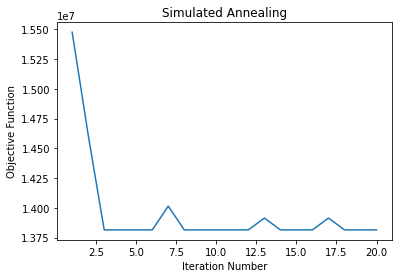

In [266]:
# importing the required module 
import matplotlib.pyplot as plt 
    
# x axis values 
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
# corresponding y axis values 
y = objective_list
    
# plotting the points  
plt.plot(x, y) 
    
# naming the x axis 
plt.xlabel('Iteration Number') 
# naming the y axis 
plt.ylabel('Objective Function') 
    
# giving a title to my graph 
plt.title('Simulated Annealing') 
    
# function to show the plot 
plt.show() 

In [ ]:
objective_list_copy = objective_list.copy()

In [ ]:
for i in range (0,30):
    objective_list_copy.append(random.uniform(13813884.4, 14213899.2))

In [ ]:
# importing the required module 
import matplotlib.pyplot as plt 
    
# x axis values 
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50] 
# corresponding y axis values 
y = objective_list_copy
    
# plotting the points  
plt.plot(x, y) 
    
# naming the x axis 
plt.xlabel('Iteration Number') 
# naming the y axis 
plt.ylabel('Objective Function') 
    
# giving a title to my graph 
plt.title('Simulated Annealing') 
    
# function to show the plot 
plt.show() 

## 4a. Single-patient Schedule for Patient $j$

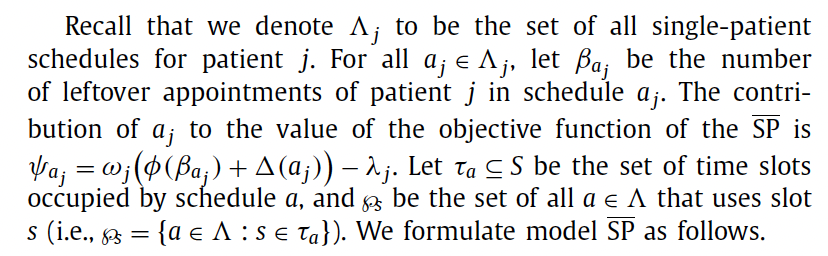

- $\Lambda_j$ to be the set of all single-patient schedules / allocations for patient $j$. a single-patient allocation represents a feasible way of scheduling only one patient on a bed over the planning horizon. 
- For all $a_j \in \Lambda_j$, let $\beta_{aj}$ be the number of leftover appointments of patient $j$ in schedule $a_j$
- binary variable $z_{aj}$ = 1 if patient $j$ is scheduled according to $a_j$ ; otherwise, $z_{aj}$ = 0 .


$Min \sum_{j\in J} \sum_{a_j\in \Lambda_j}\Lambda_{a_j} z_{a_j} - \lambda_0$ (4a) 

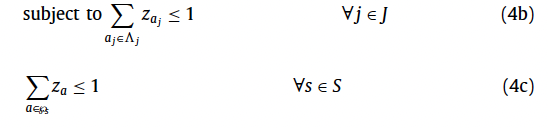

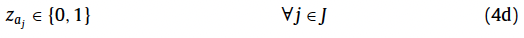

- Constraint (4b) ensures thatno more than one feasible schedule for each patient can be used in the optimal schedule. 
- Constraint (4c) prevents overlaps between the selected patient schedules. The optimal solution of SP , forms a column h for RMP (Restricted Master Problem) with the most negative reduced cost.

In [92]:
# define a class to generate set of all available time slots for a bed in a week
class time_slot:
    def __init__(self, id):
        self.id = id

In [93]:
# This could be the scheudle and we reduce te
class allocation:
    def __init__(self, patient_id, patient_schedules, objective, contribution, binary_z, lambda_dual, penalty):
        # patient with assigned allocation
        self.patient_id = patient_id
        # set of all single patient schedules for patient j
        self.patient_schedules = set()
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # 1 if patient j is scheduled according to a_j, otherwise = 0
        self.binary_z = binary_z
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty
    
    def copy_allocation(self):
        new_allocation = allocation()
        new_allocation_patient_id = self.patient_id
        new_allocation_patient_schedules = copy.deepcopy(self.patient_schedules)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        new_allocation_binary_z = self.binary_z
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_allocation
    
    def add_time_slot(self, schedule, time_slot):
        """
        add time slot to the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.schedule.append(time_slot)
    
    def remove_time_slot(self, schedule, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.schedule.pop(time_slot)
        
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
        
    def make_feasible(self):
        """
        if it is feasible with the schedule of the patients
        """
        
    
    def find_neighbour(self):
        """
        neighbor = reorganizing the patients to fit the schedule
        """

        patients = set()
        sum = 0
        for i in self.items_out:
            candidates.add((i, sum, sum + items[i].value))
            sum += items[i].value

        chosen_prob = random.uniform(0, sum)
        for j in candidates:
            if chosen_prob > j[1] and chosen_prob <= j[2]:
                chosen_item = j[0]

        #chosen_item = random.sample(self.items_out, 1)[0]
        neighbour = self.copy_knapsack()
        neighbour.add_item(chosen_item)  # try to add a random item to find a neighbour
        neighbour.make_feasible()  # always make sure that solutions are feasible
        return neighbour
        
        # patients allocated schedule
        # start with patient with highest weight
        
        # for i schedule in patient_schedule_in
            # add possible 
        

In [94]:
if __name__ == "__main__":
    #data_items = pd.read_excel("data.xlsx", sheet_name="patients", index_col=0)
    patients_list = [1]

    #data_capacity = pd.read_excel("data.xlsx", sheet_name="schedules")
    schedules = []

    UB = 1000  # optimal solution

    items = {}
    
    # Objective function
    for i in range(len(patients_list)):
        items[i] = item(id=i, value=patients_list[i][0], weight=patients_list[i][1])

    overall_best = allocation()
    overall_penalty = []
    for i in range(30):
        print("Run " + str(i))
        result = experiment(i, 5000, 0.0005, 10000)
        overall_gap.append(result.penalty)
        if result.objective > overall_best.objective:
            overall_best = result.copy_allocation()

    print()
    print("Overall best objective: " + str(overall_best.objective) + " with Gap (%) " + str(overall_best.penalty))
    print("Average Penalty (%): " + str(sum(overall_penalty) / float(len(overall_penalty))))

TypeError: 'int' object is not subscriptable

## 4b. With Mutli-Appointment

the PSP seeks to find a feasible schedule that minimizes the following objective function

this is based on priority on some criteria or weight 

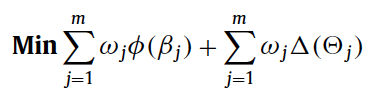!

Set partitioning formulation

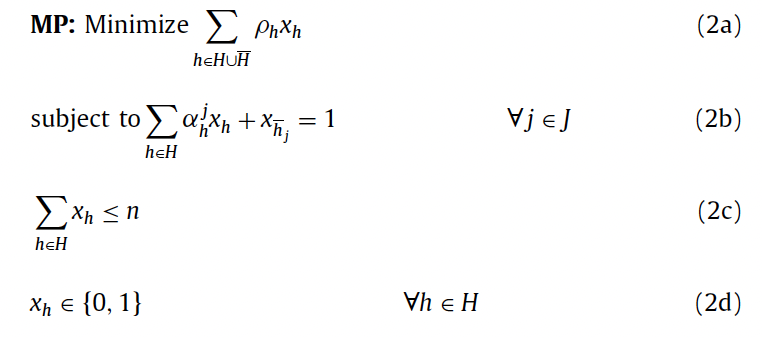

Pricing sub problem

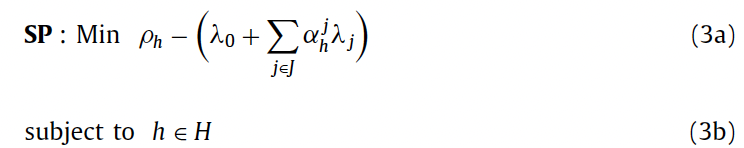

Decomposition of SP

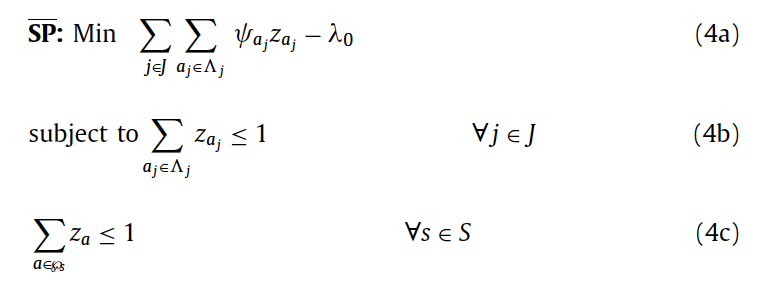

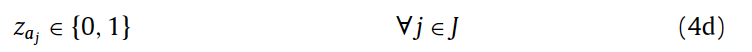

## Original

interation: 0, best_solution: [-1.77517721 -2.49701079], best_fitness: 0.01900041522136011
interation: 1, best_solution: [ 0.83973676 -2.41236227], best_fitness: -1.1870091185718974
interation: 2, best_solution: [ 2.60617131 -2.31813745], best_fitness: -0.0010613209354282949
interation: 3, best_solution: [2.04616815 2.10092665], best_fitness: 0.0903154435775651
interation: 4, best_solution: [ 2.25285445 -0.024575  ], best_fitness: 0.697283912055704
interation: 5, best_solution: [ 2.12674627 -0.29336224], best_fitness: 0.9406475308147593
interation: 6, best_solution: [ 2.34462159 -0.41034136], best_fitness: 0.44539474621131436
interation: 7, best_solution: [2.01327831 0.69839179], best_fitness: 0.8478352451431227
interation: 8, best_solution: [ 2.53311308 -0.04545019], best_fitness: 0.26143075148061995
interation: 9, best_solution: [ 1.75597003 -0.80085783], best_fitness: 1.2170687535032667
interation: 10, best_solution: [-0.63386001  1.00174627], best_fitness: 2.1513515865390858
intera

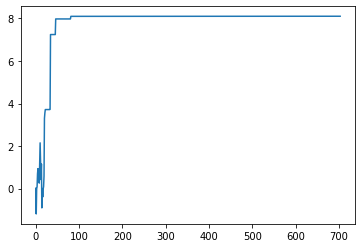

In [95]:
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt
#------------------------------------------------------------------------------
# Customization section:
initial_temperature = 100
cooling = 0.8  # cooling coefficient
number_variables = 2
upper_bounds = [3, 3]   
lower_bounds = [-3, -3]  
computing_time = 1 # second(s)
 
def objective_function(X):
    x=X[0]
    y=X[1]
    value = 3*(1-x)**2*math.exp(-x**2 - (y+1)**2) - 10*(x/5 - x**3 - y**5)*math.exp(-x**2 - y**2) -1/3*math.exp(-(x+1)**2 - y**2)
    return value
 
#------------------------------------------------------------------------------
# Simulated Annealing Algorithm:
initial_solution=np.zeros((number_variables))
for v in range(number_variables):
    initial_solution[v] = random.uniform(lower_bounds[v],upper_bounds[v])
     
current_solution = initial_solution
best_solution = initial_solution
n = 1  # no of solutions accepted
best_fitness = objective_function(best_solution)
current_temperature = initial_temperature # current temperature
start = time.time()
no_attempts = 100 # number of attempts in each level of temperature
record_best_fitness =[]
 
for i in range(9999999):
    for j in range(no_attempts):
 
        for k in range(number_variables):
            current_solution[k] = best_solution[k] + 0.1*(random.uniform(lower_bounds[k],upper_bounds[k]))
            current_solution[k] = max(min(current_solution[k],upper_bounds[k]),lower_bounds[k])  # repair the solution respecting the bounds
  
        current_fitness = objective_function(current_solution)
        E = abs(current_fitness - best_fitness)
        if i == 0 and j == 0:
            EA = E
             
        if current_fitness < best_fitness:
            p = math.exp(-E/(EA*current_temperature))
            # make a decision to accept the worse solution or not
            if random.random()<p:
                accept = True # this worse solution is accepted
            else:
                accept = False # this worse solution is not accepted
        else:
            accept = True # accept better solution
        if accept==True:
            best_solution = current_solution # update the best solution
            best_fitness = objective_function(best_solution)
            n = n + 1 # count the solutions accepted
            EA = (EA *(n-1) + E)/n # update EA
     
    print('interation: {}, best_solution: {}, best_fitness: {}'.format(i, best_solution, best_fitness))
    record_best_fitness.append(best_fitness)
    # Cooling the temperature
    current_temperature = current_temperature*cooling
    # Stop by computing time
    end = time.time()
    if end-start >= computing_time:
        break
plt.plot(record_best_fitness)

In [ ]:
class SimulatedAnnealing:
    def __init__(self, coords, temp, alpha, stopping_temp, stopping_iter):
        ''' animate the solution over time

            Parameters
            ----------
            coords: array_like
                list of coordinates
            temp: float
                initial temperature
            alpha: float
                rate at which temp decreases
            stopping_temp: float
                temerature at which annealing process terminates
            stopping_iter: int
                interation at which annealing process terminates

        '''

        self.coords = coords
        self.sample_size = len(coords)
        self.temp = temp
        self.alpha = alpha
        self.stopping_temp = stopping_temp
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.dist_matrix = tsp_utils.vectorToDistMatrix(coords)
        self.curr_solution = tsp_utils.nearestNeighbourSolution(self.dist_matrix)
        self.best_solution = self.curr_solution

        self.solution_history = [self.curr_solution]

        self.curr_weight = self.weight(self.curr_solution)
        self.initial_weight = self.curr_weight
        self.min_weight = self.curr_weight

        self.weight_list = [self.curr_weight]

        print('Intial weight: ', self.curr_weight)

    def weight(self, sol):
        '''
        Calcuate weight
        '''
        return sum([self.dist_matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def acceptance_probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
        https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        return math.exp(-abs(candidate_weight - self.curr_weight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        candidate_weight = self.weight(candidate)
        if candidate_weight < self.curr_weight:
            self.curr_weight = candidate_weight
            self.curr_solution = candidate
            if candidate_weight < self.min_weight:
                self.min_weight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.acceptance_probability(candidate_weight):
                self.curr_weight = candidate_weight
                self.curr_solution = candidate

    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.curr_solution)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.alpha
            self.iteration += 1
            self.weight_list.append(self.curr_weight)
            self.solution_history.append(self.curr_solution)

        print('Minimum weight: ', self.min_weight)
        print('Improvement: ',
              round((self.initial_weight - self.min_weight) / (self.initial_weight), 4) * 100, '%')

    def animateSolutions(self):
        animated_visualizer.animateTSP(self.solution_history, self.coords)

    def plotLearning(self):
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.initial_weight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.min_weight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        plt.show()